# Credit Card Fraud Detection


## 0. Introduction 

In this exercise, we want to develop a credit fraud detector to combat fraudulent transcations. A fraud detector can help us identify frauds so we can act on them - invesgate fraudulent events, refund mischarged amount to the victims, and define sucess metrics such as payback rates for these frauds. This will be helpful to promote trust in users' experiences.

### Process:

The general approach for Machine Learning process is as follows:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Model Evluation
6. Repeat steps 1 to 5 to build effective models
7. Deployment


### Data:

dataset can be found on Kaggle - https://www.kaggle.com/mlg-ulb/creditcardfraud

## 1. Business Understanding - 

Business motivation - We want to predict if a transaction is fraudulent or not, so that we can act on fraudulent events and protect users.

1.  Questions to consider:
    - How many transcations are we trying to identify?
    - Any priorities of population we want to start with?
    - How are we going to label the transcations we identify?
    - Are we sending them all into generic one size fits all fraudulent case management program?
    - What about regression to the mean?
    - How do we know a targeted transcation when we see one?
    - What do we know about how the business process that serves up potential candidates to the fraudulent case managers for outreach?
        
2. We might have some specific use cases later on. For example, we would want to mitigate the number of fraudulent transcations misclassified as non-fraudulent, or the other way around
    
## 2. Data Understanding

Now, we want to dig into the data to see what kind of information we can use to determine a fraudulent event

1. Exploratory Analysis based on intuition 
2. Quick summary based on different class
3. Any missing values?

        

## 3. Data Processing

This step is basically transforming the original data elements to features used in data modeling. Some useful practices include the following - 

1. Deal with unusable data elements (missing value, categorical data, etc)
2. Scaling/Standardizing
3. Define buckets
4. Feature Selection


## 4. Data modeling

We implement some popular classifier first - 

1. KNN
2. Logistic Regression
3. Decision Tree

After Step 5 model evaluation, we will check out other techinques to potentially build more effective models - 
1. Different parameters for each classifier
2. Different features fed into each classifier
3. Ensembling models (Combination of some weak learners)

## 5. Model Evaluation

1. __CrossValidation__: Pick the parameters of a classifier for best estimator
2. __Learning Curve__: The plot can help us understand bias and variance for each classifier. Eventually, we want to lines to converge to a good score
3. __Confusion Matrix__ (Accuracy, precision and recall)
4. __ROC curve__
        


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix


from sklearn.utils.testing import ignore_warnings

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Data Understanding

Now, we want to dig into the data to see what kind of information we have to determine a fraudulent event

    1. Exploratory Analysis based on intuition 
        - Available inofmration
            - PCA transformed data: V1 - V28. These are principle components, we do not have any other information
            - Time/Amount: These might be important features to determine target
            - Class: Target
        - % frauds among all transcations
        - What about the variables that are not scaled?
        - Do fraudulent transcations have a different processing time/amount compared against non-fraudulent ones?
        - Correlation between the variables
    
    2. Findings and potential problems to address
        - Q1: Amount has large variance and is not scaled/standardized. Would this be a problem since most of the other features are scaled (PCA)?
        - A1: Some algorithms such as KNN use Euclidean Distance measure, which are sensitive to magnitudes. Scaling would help weigh all the features equally. For other learners such as decision tree, it might not be a problem
        
        - Q2: The fraudluent transcations is only 0.17% of all transcations. The data is unbalanced. What should we do?
        - A2: We can sampling the data. Not sure if undersampling would be a good idea because we will lose a lot of information. We will try oversampling SMOTE technique to see if it can help identiy fraudulent transcation
        
        - Q3: Do we need to include all the variables for all the classifiers we want to implement?
        - A3: Maybe or maybe not. We can try feature selection methods to see if we can get a better result when reducing the number of features. Although, we've already applied PCA

In [2]:
# Read CSV files
data_dir = '/Users/timyu/Desktop/ML_Projects/Credit_Fraud/'
credit_fraud_data = pd.read_csv('creditcard.csv')

Let's take a quick look at the data first

In [3]:
credit_fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We don't have much information on V1 - V28. But let's see how many fraudulent transcations are in the dataset 

Fraud Ratio: 0.17275%


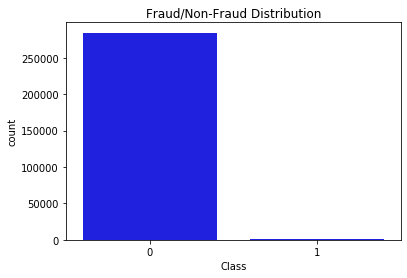

In [4]:
# Calculate the credit fraud ratio
fraud_ratio = sum(credit_fraud_data['Class']==1)/len(credit_fraud_data['Class'])
print('Fraud Ratio: {0:.5%}'.format(fraud_ratio))
sns.countplot(credit_fraud_data['Class'], color='blue')
plt.title('Fraud/Non-Fraud Distribution')
plt.show()

We only have 0.17% fraudulent transcations in the data! This is an unbalanced dataset. We might want to do some sampling to see if it would help us develop a better prediction. But let's continue with more exploratory analyses. We have summaries of transcation time and amount by different class (fraudulent/normal) 

In [5]:
# Quick Summary based on class
credit_fraud_data[['Amount', 'Class']].groupby('Class').describe()

Amount                                                            
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87

In [6]:
credit_fraud_data[['Time', 'Class']].groupby('Class').describe()

Time                                                       \
          count          mean           std    min      25%      50%   
Class                                                                  
0      284315.0  94838.202258  47484.015786    0.0  54230.0  84711.0   
1         492.0  80746.806911  47835.365138  406.0  41241.5  75568.5   

                           
            75%       max  
Class                      
0      139333.0  172792.0  
1      128483.0  170348.0

data visualization for transcation time and amount by different class

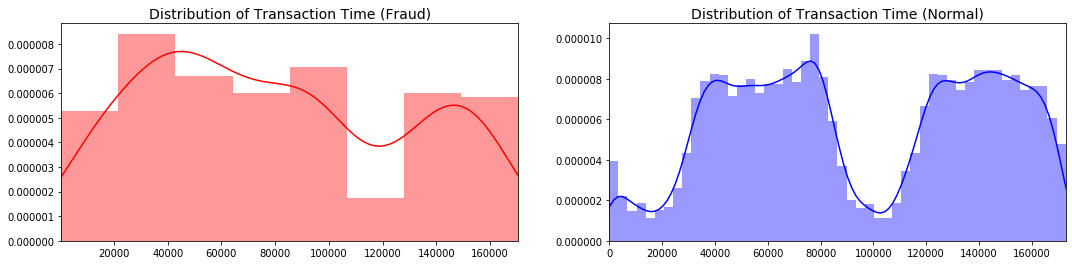

In [7]:
fraud = credit_fraud_data[credit_fraud_data['Class'] == 1].Time.values
normal = credit_fraud_data[credit_fraud_data['Class'] == 0].Time.values

fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.distplot(fraud, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Time (Fraud)', fontsize=14)
ax[0].set_xlim([min(fraud), max(fraud)])

sns.distplot(normal, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time (Normal)', fontsize=14)
ax[1].set_xlim([min(normal), max(normal)])



plt.show()

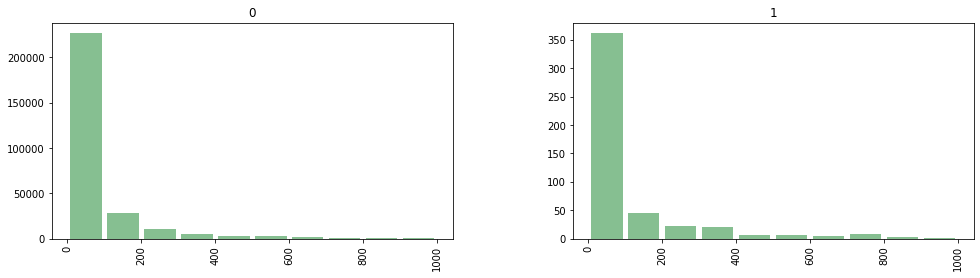

In [8]:
ax = credit_fraud_data.hist(column='Amount', by='Class', color='#86bf91', rwidth=0.85, range=[0, 1000], 
                            figsize=(16, 4))

plt.show()

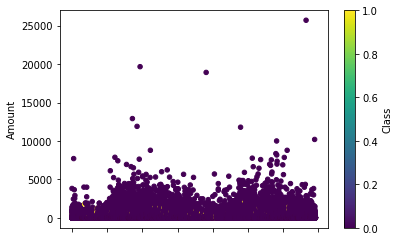

In [9]:
ax2 = credit_fraud_data.plot.scatter(x='Time',
                       y='Amount',
                       c='Class',
                       colormap='viridis')
plt.show()

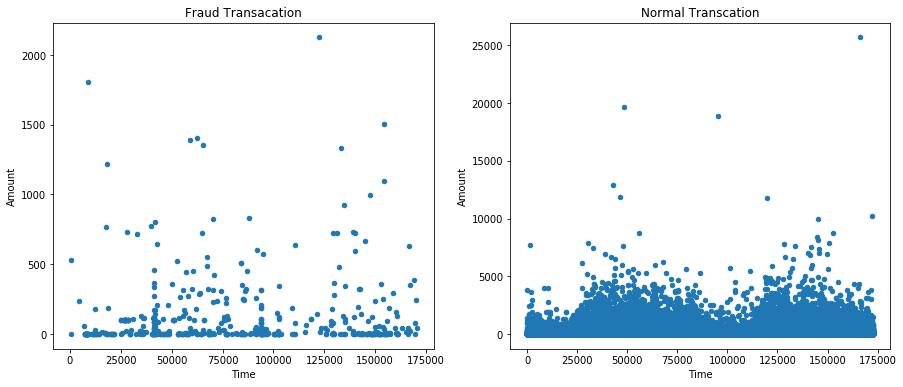

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
credit_fraud_data[credit_fraud_data["Class"]==1].plot.scatter(x='Time', y='Amount', title='Fraud Transacation', ax=ax[0])
credit_fraud_data[credit_fraud_data["Class"]==0].plot.scatter(x='Time', y='Amount', title = 'Normal Transcation', ax=ax[1])

plt.show()

### __Observations__

1. The distribution of transcation amount for fraudulent transcations are similar to the one for normal transcations
2. The average of fraudulent transcation amount is higher than the average of normal transcation amount
3. The fraudulent transcation time distribution looks more uniform than the normal one (there's a dip for 120000 secods after the first transaction in the dataset for frudulent transcations, and another one 80000-120000 for normal transcations. There might be some external force happening that impacted the transcations)
4. The overall variance of time and amount is pretty much the same

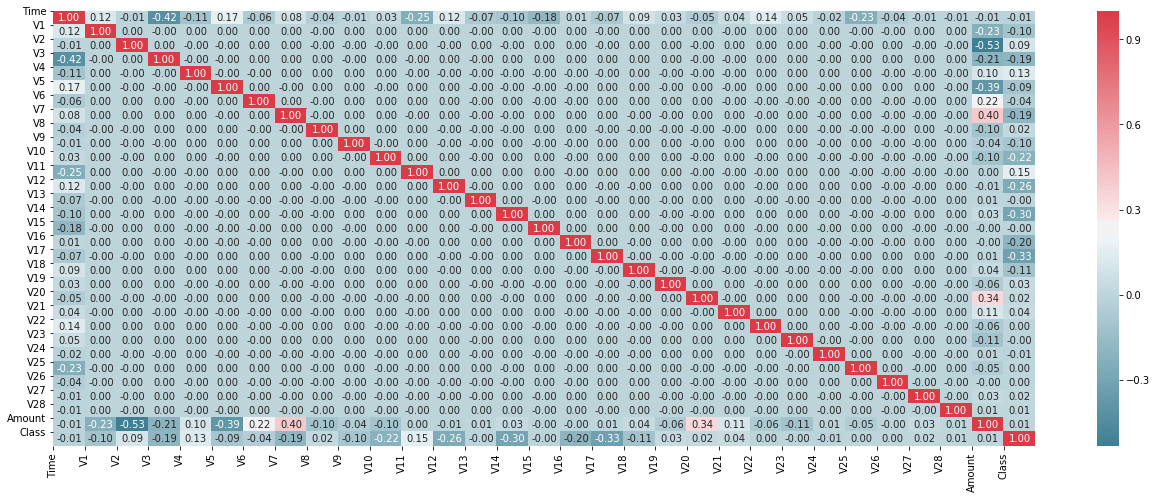

In [11]:
def corr_heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(22, 8))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

corr_heatMap(credit_fraud_data)

There are some principal components that correlated with time and amount for more than 0.5, but we don't have enough evidence to decide if we should drop any variables

### __Key Takeaways__

1. We need to scale the transcation time and amount in the step of data processing
2. We might need to apply some sampling techniques (oversampling or undersampling) to see if it can help predict the fraudulent transcations. Using this original data might cause the following problems:
    - Overfitting: Our classification models will assume that in most cases there are no frauds. What we want for our model is to be certain when a fraud occurs. 
    - Wrong Correlations: Although we don't know what the V1-V28 features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.


## __3. Data Processing__

First of all, let's scale time and amount. RobustScaler is less prone to outliers than StandardScaler

In [12]:
rob_scaler = RobustScaler()

credit_fraud_data['scaled_amount'] = rob_scaler.fit_transform(credit_fraud_data['Amount'].values.reshape(-1,1))
credit_fraud_data['scaled_time'] = rob_scaler.fit_transform(credit_fraud_data['Time'].values.reshape(-1,1))

In [13]:
# Assign X, y for features and targets
X = credit_fraud_data.drop(['Class', 'Amount', 'Time'], axis=1)
y = credit_fraud_data['Class']

We can split the dataset into training and testing set first. We will later on use cross validation to split the training set into training and validation sets

In [14]:
# Seperate the datasets into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

## __4. Data modeling__

We implement some popular classifiers first - 

    1. KNN
    2. Logistic Regression
    3. Decision Tree

We use 5-fold cross validation to calculate the best parameters for each classifier based on f1 score. We don't use the default accuracy is because our training set is heavily imbalanced (only a few fraudulent transcations), and we don't want a model that has really good accuracy but with low precision and recall (good at predicting non-fraudulent transcation all the time but bad at predicting fraudulent transcations). Therefore, we choose f1 score (a combination of precision and recall) to evaulate the parameters

In [15]:
# KNN Classifier

# Set parameters for Cross-Validation
knears_params = {"n_neighbors": list(range(2,8,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Use GridSearchCV function to perform cross-validation
grid_knn = GridSearchCV(KNeighborsClassifier(metric = 'minkowski'), knears_params, scoring='f1', cv=5)

# Fit the model using training set
grid_knn.fit(X_train, y_train)

grid_knn.cv_results_

# Get the KNN classifier with the best parameters.
knn = grid_knn.best_estimator_

In [16]:
# Logistic Regression 

# Set parameters for Cross-Validation
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Use GridSearchCV function to perform cross-validation
grid_log_reg = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter = 4000, penalty='l2'), log_reg_params, scoring='f1', cv=5)

# Fit the model using training set
grid_log_reg.fit(X_train, y_train)

# Get the logistic regression classifier with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [17]:
# DecisionTree Classifier

# Set parameters for Cross-Validation
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(5,15,1)), 
              "min_samples_leaf": list(range(5,7,1))}

# Use GridSearchCV function to perform cross-validation
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, scoring='f1', cv=5)

# Fit the model using training set
grid_tree.fit(X_train, y_train)

# Get the Decision Tree classifier with the best estimator
tree = grid_tree.best_estimator_

Let's take a look at the results first to see how these models perform with different parameters

In [19]:
grid_knn.cv_results_

{'mean_fit_time': array([0.50549526, 0.48398652, 0.51820703, 0.56922412, 1.78261776,
        0.88922691, 0.56726899, 0.6220026 , 0.57675843, 0.62900229,
        0.55044389, 0.8742702 , 0.56277571, 0.67299032, 0.53367276,
        0.6248076 , 0.52134643, 0.49558959, 0.08630905, 0.13380055,
        0.21268735, 0.13731737, 0.26880302, 0.34986796]),
 'std_fit_time': array([0.05717498, 0.01424329, 0.03637854, 0.14957242, 1.46837669,
        0.4991381 , 0.03372049, 0.11932292, 0.01861062, 0.11758956,
        0.02098394, 0.15744286, 0.12362795, 0.25444034, 0.01045657,
        0.14708418, 0.02206712, 0.02017683, 0.08480266, 0.10526435,
        0.11515896, 0.10685947, 0.09698947, 0.10372915]),
 'mean_score_time': array([  77.16843281,   91.70110359,  449.41042724,  456.92938581,
         385.59421334,  184.01097951,  563.66134658,  601.11734128,
         615.38697672,  627.44511943,  630.67721891,  695.66709461,
         136.73484864,  346.62602921,  171.00185046,  120.34063554,
         120.821

In [20]:
grid_log_reg.cv_results_

{'mean_fit_time': array([1.03199773, 1.82959404, 4.22961292, 5.41627793, 5.88849235,
        5.1547842 , 6.57424631]),
 'std_fit_time': array([0.07567396, 0.10252666, 1.6140388 , 1.61388024, 2.21219099,
        1.38935471, 1.87649775]),
 'mean_score_time': array([0.0316597 , 0.03482227, 0.04788928, 0.04829416, 0.05023975,
        0.07185593, 0.04048796]),
 'std_score_time': array([0.00418787, 0.00175723, 0.02052971, 0.01899601, 0.02071081,
        0.04978812, 0.00245026]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 1000}],
 'split0_test_score': array([0.62121212, 0.69117647, 0.72857143, 0.75524476, 0.76388889,
        0.76388889, 0.76388889]),
 'split1_test_score': array([0.6870229 , 0.72992701, 0.72592593, 0.73529412, 0.73529412,
        0.

In [21]:
grid_tree.cv_results_

{'mean_fit_time': array([11.17004213,  8.30208244, 11.29559498,  8.37861118,  9.94628587,
         9.70482011, 11.1405921 , 11.72307482, 12.71265903, 12.94105821,
        13.50737796, 18.32716861, 14.65672336, 15.135109  , 16.01113429,
        16.68058167, 22.16470037, 17.74128022, 18.45211506, 18.27840009,
         8.58552232,  8.45034451, 10.11221337,  9.87636666, 11.28933339,
        11.72457576, 14.79531422, 12.77145805, 12.77503619, 12.86345463,
        13.46683912, 12.95647836, 12.97445865, 13.09122024, 13.14321752,
        18.83145518, 19.82753701, 15.24946752, 13.88988118, 13.29148178]),
 'std_fit_time': array([1.63646879, 1.65793072, 3.05017579, 0.05074341, 0.26281257,
        0.01952151, 0.03837719, 0.32206914, 0.35407296, 0.32216858,
        0.32668923, 3.32821346, 0.37373226, 0.13849852, 0.43231064,
        0.42009185, 4.75746783, 0.51464408, 0.44183735, 0.41175488,
        0.22826005, 0.11273923, 0.37662909, 0.2355133 , 0.59529608,
        1.46862604, 2.00974878, 0.9680600

Once we determine the best parameter for each classifier, we want to look at some metrics when performing cross validation with such parameter

1. Accuracy
2. Precision
3. Recall
4. F1

In [22]:
for s in ['accuracy', 'precision', 'recall', 'f1']:

    print(s)
    knn_score = cross_val_score(knn, X_train, y_train, cv=5, scoring=s)
    print('KNN Cross Validation Score {}: '.format(s), round(knn_score.mean() * 100, 2).astype(str) + '%')

    log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5, scoring=s)
    print('Logistic Regression Cross Validation Score {}: '.format(s), round(log_reg_score.mean() * 100, 2).astype(str) + '%')

    tree_score = cross_val_score(tree, X_train, y_train, cv=5, scoring=s)
    print('Decision Tree Cross Validation Score {}: '.format(s), round(tree_score.mean() * 100, 2).astype(str) + '%')
    print('---' * 30)

accuracy
KNN Cross Validation Score accuracy:  99.95%
Logistic Regression Cross Validation Score accuracy:  99.92%
Decision Tree Cross Validation Score accuracy:  99.94%
------------------------------------------------------------------------------------------
precision
KNN Cross Validation Score precision:  92.45%
Logistic Regression Cross Validation Score precision:  89.01%
Decision Tree Cross Validation Score precision:  88.84%
------------------------------------------------------------------------------------------
recall
KNN Cross Validation Score recall:  78.02%
Logistic Regression Cross Validation Score recall:  65.19%
Decision Tree Cross Validation Score recall:  76.54%
------------------------------------------------------------------------------------------
f1
KNN Cross Validation Score f1:  84.61%
Logistic Regression Cross Validation Score f1:  75.16%
Decision Tree Cross Validation Score f1:  82.38%
---------------------------------------------------------------------------

### __Learning Curve__

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data

Overall, we can use the learning curve plot to diagnose model behavior - overfit, underfit or good fit

In [23]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, scoring='accuracy', train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
        
    scoring : string, optional (default=accuracy)
        the scoring method

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return train_sizes, train_scores, test_scores, plt

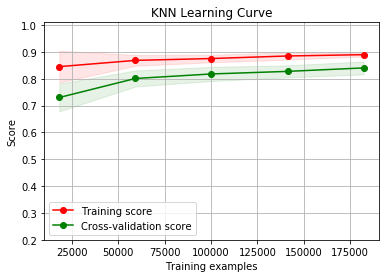

In [24]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
#cv=5
train_sizes1, train_scores1, test_scores1, plt1 = plot_learning_curve(estimator=knn, title='KNN Learning Curve', 
                                                                  X=X_train, y=y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4, scoring='f1')

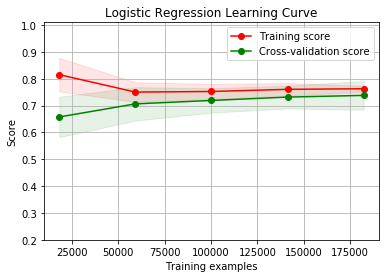

In [25]:
train_sizes2, train_scores2, test_scores2, plt2 = plot_learning_curve(estimator=log_reg, title='Logistic Regression Learning Curve', 
                                                                  X=X_train, y=y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4, scoring='f1')

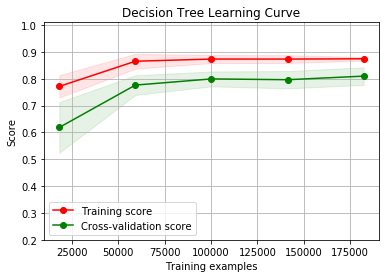

In [26]:
train_sizes3, train_scores3, test_scores3, plt3 = plot_learning_curve(estimator=tree, title='Decision Tree Learning Curve', 
                                                                  X=X_train, y=y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4, scoring='f1')

### __Key Takeaways__

1. Increase in training size is good for all classifier
2. Decision Tree will have the largest variance amount all 3 classifiers
3. KNN has the best cross validation score

Now, let's use the classifiers to make predictions based on testing set

In [27]:
y_pred_knn = knn.predict(X_test)
y_pred_log = log_reg.predict(X_test)
y_pred_tree = tree.predict(X_test)

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




### __Confusion Matrix__

Confusion matrix can help us understand if our models are good or not. We don't just care about accuracy. We want to focus on the 2 metrics -

1. Precision: How many elements selected are relevant. In this case, it's the % of predicted fraudulent transcations are actually frauds
2. Recall: How many relevant elements are selected. In this case it's the percentage of fraudulent transcations that are identified as frauds

Confusion matrix, without normalization
[[56870     5]
 [   20    67]]
Normalized confusion matrix
[[1.00e+00 8.79e-05]
 [2.30e-01 7.70e-01]]


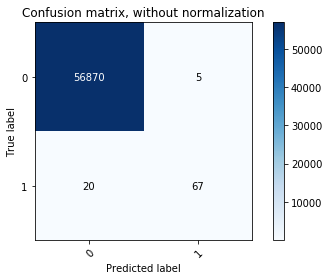

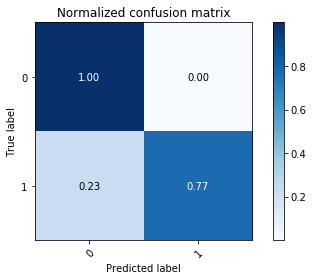

In [29]:
np.set_printoptions(precision=2)

class_names = [0, 1]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_knn, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_knn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[56865    10]
 [   39    48]]
Normalized confusion matrix
[[1.00e+00 1.76e-04]
 [4.48e-01 5.52e-01]]


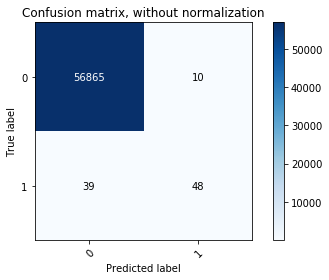

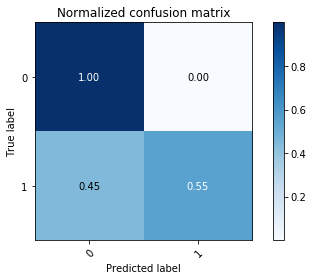

In [30]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_log, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_log, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[56867     8]
 [   22    65]]
Normalized confusion matrix
[[1.00e+00 1.41e-04]
 [2.53e-01 7.47e-01]]


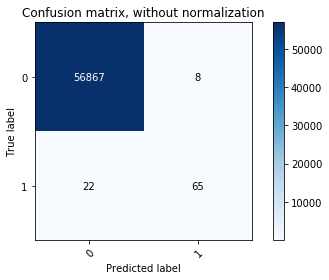

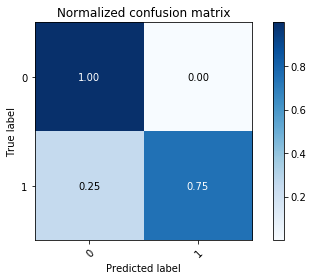

In [31]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_tree, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_tree, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [32]:
# Check out all the metrics
from sklearn.metrics import classification_report

def clf_metrics(classifier, testing_set, prediction):
    print('{} Classifier Report: '.format(classifier))
    print(classification_report(testing_set, prediction))
    print('---' * 30)



clf_metrics('KNN', y_test, y_pred_knn)
clf_metrics('Logistic Regression', y_test, y_pred_log)
clf_metrics('Decision Tree', y_test, y_pred_tree)

KNN Classifier Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.93      0.77      0.84        87

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------------------------------------
Logistic Regression Classifier Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.83      0.55      0.66        87

    accuracy                           1.00     56962
   macro avg       0.91      0.78      0.83     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------------------------------------
Decision Tree Classifier Report: 
              precision    recall  f1-score   support

           

### __Results__

Our KNN model looks pretty good - 

1. 97% of predicted fraudulent transcations are actually fraudulent
2. 89% overall fraudulent transcations are identified